In [1]:
import os
import pandas as pd
import numpy as np
os.chdir('..')
import ttools #homemade module
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')
from matplotlib import pyplot as pl
%matplotlib inline

## 1. Get the sample of parsed AVL data.
Clean MTA prefixes from trip_id

In [2]:
# get the sample of parsed AVL data.  Beware, large files take more time.
bustime = pd.read_csv('dec2015_extract_cleaned.csv')
bustime.drop_duplicates(['vehicle_id','recorded_time'],inplace=True)
#bustime['trip_id'] = bustime['trip_id'].str.replace('MTA NYCT_','')
#bustime['trip_id'] = bustime['trip_id'].str.replace('MTABC_','')
#bustime['shape_id'] = bustime['shape_id'].str.replace('MTA_','')

bustime.set_index(['ROUTE_ID','TRIP_ID','trip_date','vehicle_id'],inplace=True,drop=True)
bustime.set_index('recorded_time',append=True,drop=False,inplace=True)

bustime.sort_index(inplace=True)

In [3]:
bustime['distance_shape'] = bustime['distance_shape'].convert_objects(convert_numeric=True)
bustime['distance_stop'] = bustime['distance_stop'].convert_objects(convert_numeric=True)
# add calculated column for distance along shape
bustime['veh_dist_along_shape'] = bustime['distance_shape'] - bustime['distance_stop']

print 'Finished loading BusTime data and calculating distances.'

Finished loading BusTime data and calculating distances.


In [15]:
bustime_distances = bustime.drop(['recorded_time'],axis=1,inplace=False)
bustime_distances = bustime_distances.reset_index().drop(['ROUTE_ID','TRIP_ID','trip_date','vehicle_id','recorded_time',
                                                'latitude','longitude','distance_stop','status','destination'
                                                'veh_dist_along_shape'],axis=1,inplace=False)

stop_distances = bustime_distances.drop_duplicates(['SHAPE_ID','STOP_ID','distance_shape'])
stop_distances = stop_distances.query('distance_shape > 0.1')

# stop_distances.next_stop_id = stop_distances.next_stop_id.str.replace('MTA_','')

stop_distances = stop_distances.sort(['SHAPE_ID','distance_shape']).reset_index(drop=True)

print 'Finished creating stop-distances reference dataframe.'

Finished creating stop-distances reference dataframe.


In [4]:
for name, group in bustime.groupby(level=2):
    bustime.loc[(slice(None),slice(None),name),'recorded_time'] = group['recorded_time'].apply(ttools.parseActualTime,tdate=name)

## 2. calculate distance, duration and speed between each reported location, based on distance fields.

In [6]:
bg = bustime.groupby(level=(0,1,2,3))

In [8]:
bustime['seg_duration'] = bg['recorded_time'].diff()/1000000000

In [12]:
bustime['seg_dist'] = bg['veh_dist_along_shape'].diff()
bustime['seg_speed'] = bg['veh_dist_along_shape'].diff()/(bg['recorded_time'].diff()/1000000000)

In [14]:
bustime.to_pickle('dec2015_with_speeds.pickle')

In [19]:
stop_distances.set_index(['SHAPE_ID','STOP_ID'],inplace=True)

## 3. For each shape, resample the distribution of average speeds at some interval along the shape.

In [22]:
def speeds_along_shape_ticks(shape_df,ticks=200,stopspeed=0.5):
    results_df = pd.DataFrame(columns=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max','stopped_count'])
    max_dist = shape_df.veh_dist_along_shape.max()
    maxtick = int(ticks*np.ceil(max_dist/ticks))
    for d in range(0,maxtick,ticks):
        subset = shape_df.query('veh_dist_along_shape >= @d & seg_dist <= 1000').groupby(level=(0,1,2,3)).first()['seg_speed']
        descr_stats = subset.describe()
        descr_stats.name = d
        descr_stats['stopped_count'] = sum(subset<stopspeed)
        results_df = results_df.append(descr_stats)
    return results_df

In [48]:
stop_ticks = list(stop_dist_df['distance_shape'].astype(int))

In [56]:
stop_ticks = list(stop_dist_df['distance_shape'].astype(int)-10)[1:]

In [57]:
stop_ticks

[279,
 417,
 550,
 835,
 992,
 1106,
 1313,
 1495,
 1649,
 1828,
 2056,
 2211,
 2366,
 2465,
 2831,
 2997,
 3133,
 3593,
 4284,
 4538,
 4696,
 4865,
 4984,
 5212,
 5413,
 5658,
 5889,
 6000,
 6191,
 6389,
 6624,
 6861,
 7101,
 7345,
 7581,
 7819,
 7883,
 8141,
 8343,
 8609,
 8851,
 9126,
 9271,
 9558,
 9795,
 10114,
 10463,
 10649,
 10871]

In [64]:
def speeds_along_shape_stops(shape_df,stop_dist_df,stopspeed=0.5):
    results_df = pd.DataFrame(columns=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max','stopped_count'])
    stop_ticks = list(stop_dist_df['distance_shape'].astype(int))
    between_stop_ticks = [(a+b)/2 for a,b in zip(stop_ticks[:-1],stop_ticks[1:])]
    stop_ticks = list(stop_dist_df['distance_shape'].astype(int)-0.1)[1:]
    all_ticks = stop_ticks + between_stop_ticks
    all_ticks.sort()
    for d in all_ticks:
        subset = shape_df.query('veh_dist_along_shape >= @d & seg_dist <= 1000').groupby(level=(0,1,2,3)).first()['seg_speed']
        descr_stats = subset.describe()
        descr_stats.name = d
        descr_stats['stopped_count'] = sum(subset<stopspeed)
        results_df = results_df.append(descr_stats)
    return results_df

Show examples

In [46]:
stop_dist_df = stop_distances.loc['B1O0243']

In [66]:
example_df1 = speeds_along_shape_stops(bustime.query('SHAPE_ID == "B1O0243"'),stop_dist_df)

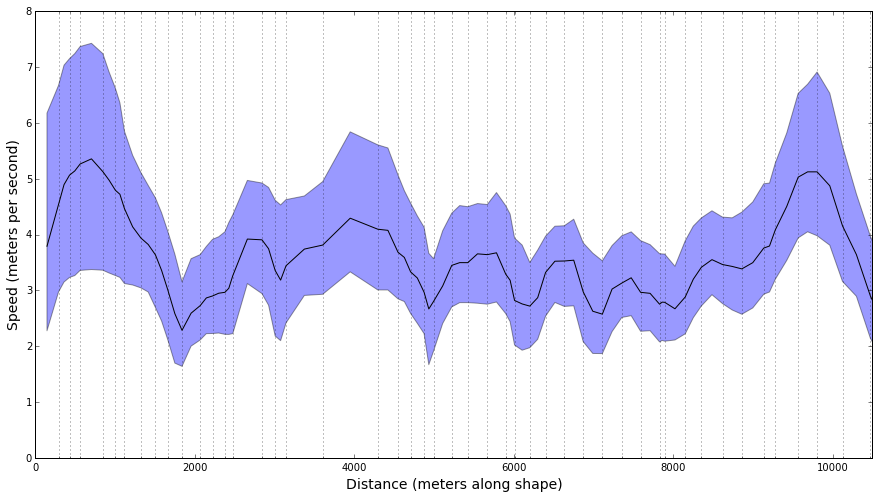

In [124]:
stop_ticks = list(stop_dist_df['distance_shape'].astype(int))
x = list(example_df1.index.values)
y = example_df1['50%'].values
upper = example_df1['75%'].values
lower = example_df1['25%'].values
fig, ax = pl.subplots(1,1,figsize=(15,8))
ax.set_xticks(stop_ticks, minor=True)
ax.xaxis.grid(True, which='minor')
ax.plot(x, y, 'k-')

ax.fill_between(x, lower, upper,alpha=0.4)
pl.ylabel('Speed (meters per second)', fontsize=14)
pl.xlabel('Distance (meters along shape)', fontsize=14)
# pl.title('Moving Distribution of Resampled Average Speed According to Distance')
pl.xlim(0,10500)
pl.savefig('/gpfs2/projects/project-bus_capstone_2016/workspace//mu529/Bus-Capstone/plots/moving_speed_distribution.png')
pl.show()

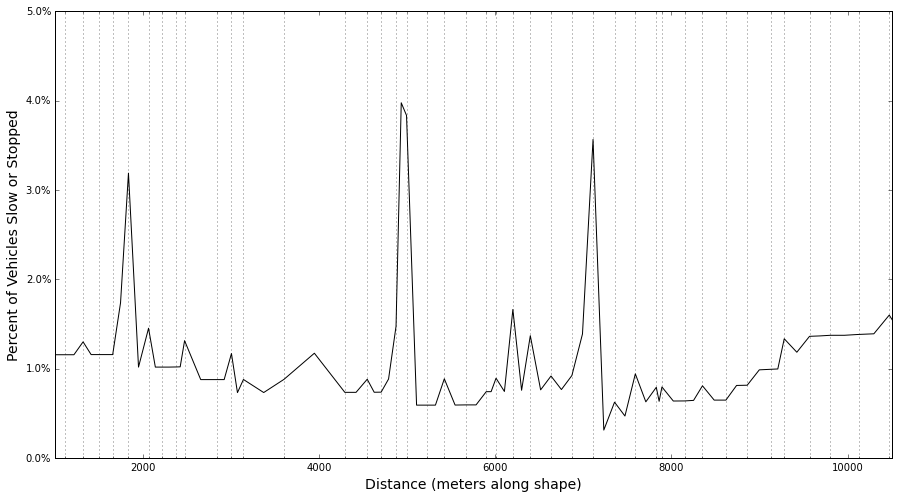

In [125]:
stop_ticks = list(stop_dist_df['distance_shape'].astype(int))
x = list(example_df1.index.values)
y = example_df1['stopped_count'].values/example_df1['count'].values
fig, ax = pl.subplots(1,1,figsize=(15,8))
ax.set_xticks(stop_ticks, minor=True)

ax.xaxis.grid(True, which='minor')
ax.plot(x, y, 'k-')
pl.ylabel('Percent of Vehicles Slow or Stopped', fontsize=14)
pl.xlabel('Distance (meters along shape)', fontsize=14)
# pl.title('Percent of Vehicles at Slow or Stopped Speed According to Distance')
pl.xlim(1000,10500)
pl.ylim(0,0.05)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.1f}%'.format(x*100) for x in vals])
pl.savefig('/gpfs2/projects/project-bus_capstone_2016/workspace//mu529/Bus-Capstone/plots/percent_vehicles_slow_or_stopped.png')
pl.show()

In [67]:
example_df2 = speeds_along_shape_ticks(bustime.query('SHAPE_ID == "B1O0243"'))

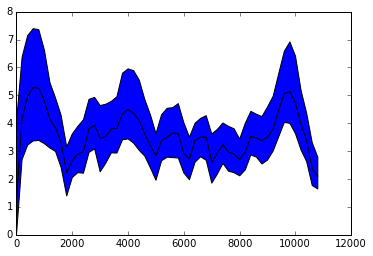

In [71]:
x = list(example_df2.index.values)
y = example_df2['50%'].values
upper = example_df2['75%'].values
lower = example_df2['25%'].values
pl.plot(x, y, 'k-')
pl.fill_between(x, lower, upper)
pl.show()

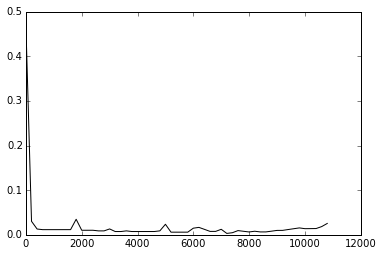

In [74]:
x = list(example_df2.index.values)
y = example_df2['stopped_count'].values/example_df2['count'].values
pl.plot(x, y, 'k-')
pl.show()

Compile results for the most common shapes and export

In [36]:
shape_groups = bustime.groupby('shape_id').size()
most_common_shapes = [shape_groups.index[i] for i, x in enumerate(shape_groups>2000) if x]

In [49]:
all_results = pd.DataFrame()
for s in most_common_shapes:
    shape_results = speeds_along_shape(bustime.query('shape_id == @s'))
    shape_results['SHAPE_ID'] = s
    shape_results = shape_results.set_index('SHAPE_ID',append=True)
    all_results = all_results.append(shape_results.swaplevel(0,1))

KeyboardInterrupt: 

In [52]:
all_results.to_csv('shape_speed_distributions.csv')